<a href="https://colab.research.google.com/github/Praveer1201/CODSOFT/blob/main/Customer_Churn_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction

In [27]:
!pip install category_encoders
# Misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
import gc
import warnings
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [28]:
# Seaborn
rc = {
    "axes.facecolor": "#FAEEE9",
    "figure.facecolor": "#FAEEE9",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "arial",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Functions
def print_sl():
    print("=" * 50)
    print()

def show_na(df, column):
    sns.countplot(x='outcome', data=df[df[column].isnull()])
    plt.show()

**Load Data**

In [31]:
train = pd.read_csv('/content/Churn_Modelling.csv')
test = pd.read_csv('/content/Churn_Modelling.csv')
sample_submission = pd.read_csv('/content/Churn_Modelling.csv')

train_orig = pd.read_csv('/content/Churn_Modelling.csv')

train.drop('CustomerId',axis=1,inplace=True)
test.drop('CustomerId',axis=1,inplace=True)
train_orig.drop('RowNumber', axis=1, inplace=True)

print('Data Loaded Succesfully!')
print_sl()

print(f'train shape: {train.shape}')
print(f'are there any null values in train: {train.isnull().any().any()}\n')

print(f'test shape: {test.shape}')
print(f'are there any null values in test: {test.isnull().any().any()}\n')

print(f'train_orig shape: {train_orig.shape}')
print(f'are there any null values in test: {train_orig.isnull().any().any()}\n')

categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

num_cols = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']

target = 'Exited'

train.head()

Data Loaded Succesfully!

train shape: (10000, 13)
are there any null values in train: False

test shape: (10000, 13)
are there any null values in test: False

train_orig shape: (10000, 13)
are there any null values in test: False



,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# ** EDA**

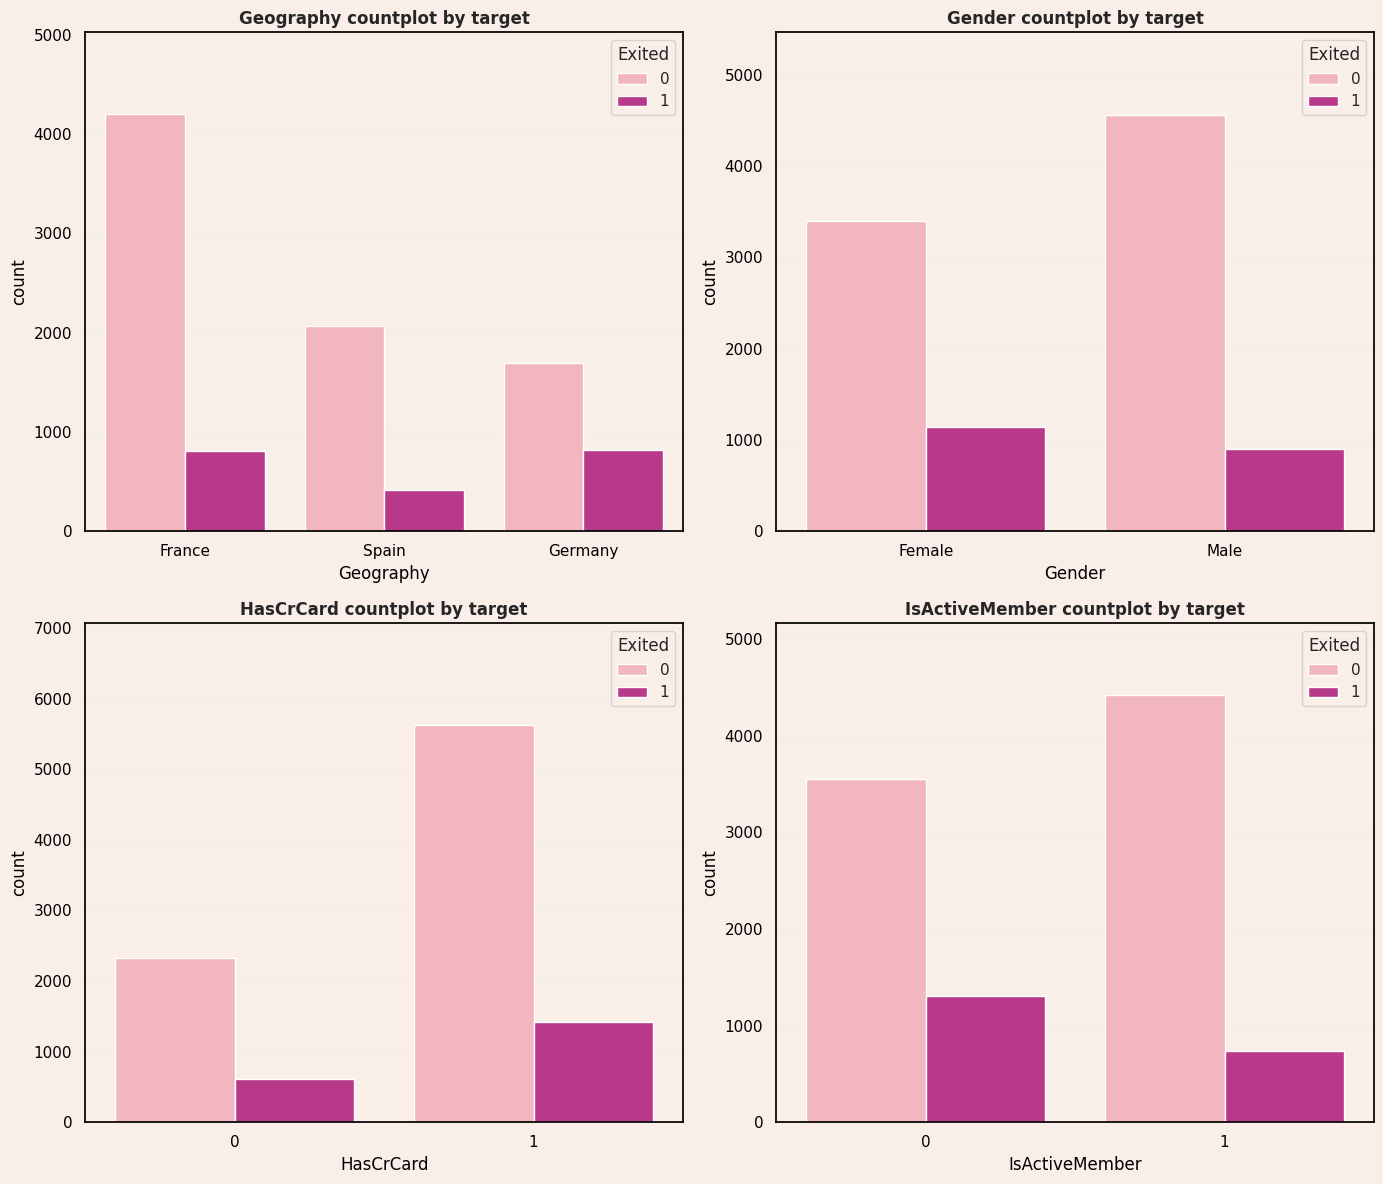

In [32]:
plt.figure(figsize=(14, len(categorical_cols)*3))

for i, col in enumerate(categorical_cols):

    plt.subplot(len(categorical_cols)//2 + len(categorical_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=train, palette='RdPu')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, train[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()

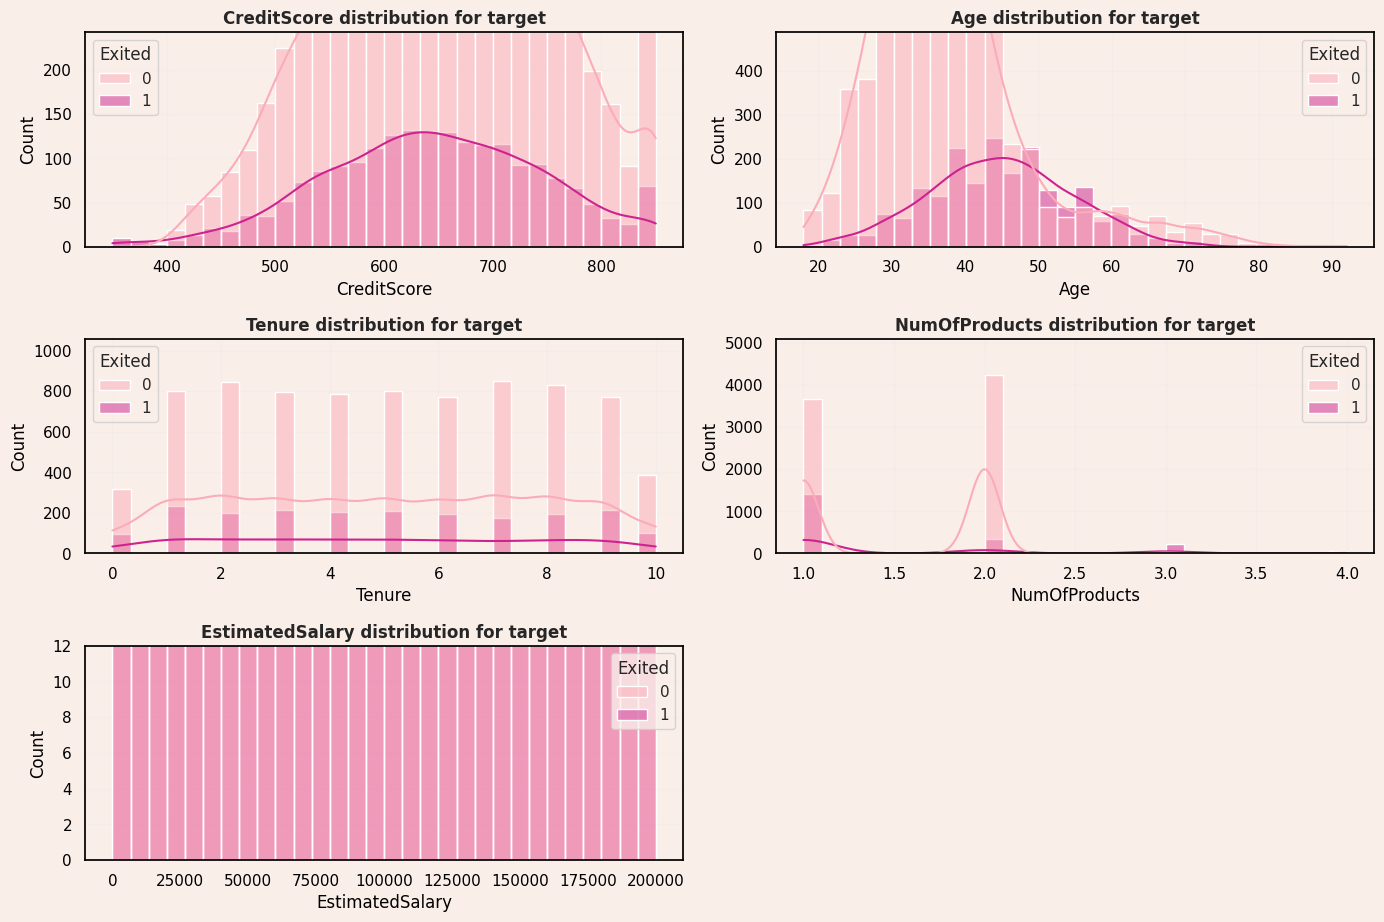

In [33]:
plt.figure(figsize=(14, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    # Plotting for outcome
    plt.subplot(len(num_cols), 2, i+1)
    sns.histplot(x=col, hue=target, data=train, bins=30, kde=True, palette='RdPu')
    plt.title(f"{col} distribution for target", fontweight="bold")
    plt.ylim(0, train[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()

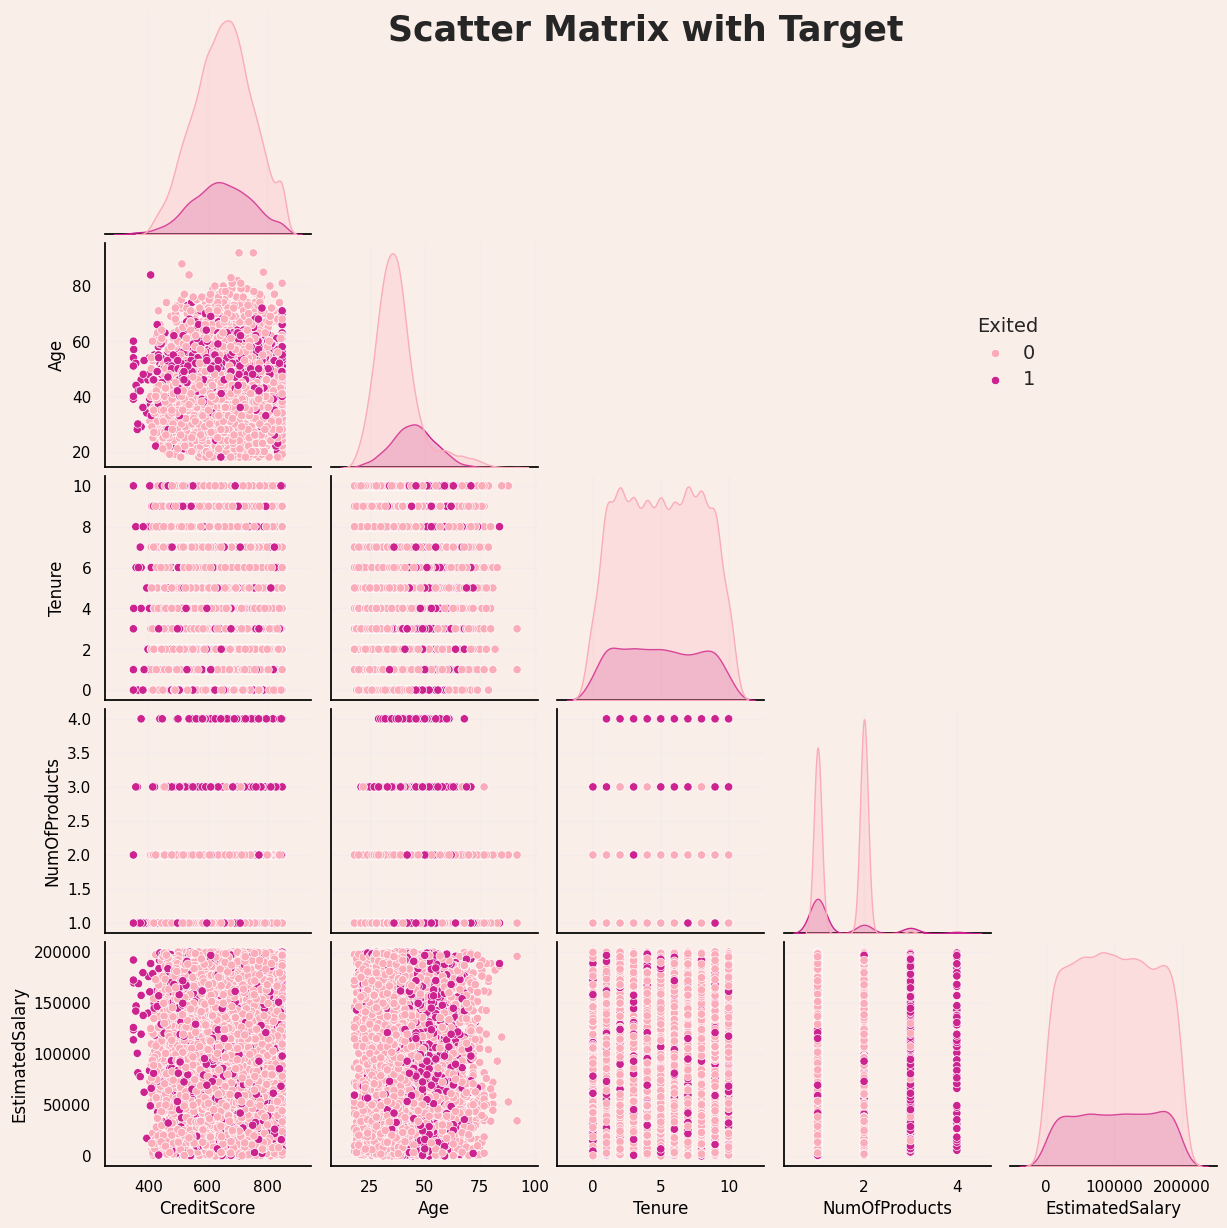

In [34]:
def plot_pair(df_train,num_var,target,plotname):
    '''
    Funtion to make a pairplot:
    df_train: total data
    num_var: a list of numeric variable
    target: target variable
    '''
    g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True,  palette='RdPu')
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper left'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

plot_pair(train, num_cols, target, plotname = 'Scatter Matrix with Target')

**Data Cleaning**


In [40]:
# transform surname.
label_enc = LabelEncoder()

train["Surname"] = label_enc.fit_transform(train[["Surname"]])
test["Surname"] = label_enc.fit_transform(test[["Surname"]])
train_orig["Surname"] = label_enc.fit_transform(train_orig["Surname"])

train['logarithm_balance'] = np.log1p(train['Balance'])
test['logarithm_balance'] = np.log1p(test['Balance'])
train_orig['logarithm_balance'] = np.log1p(train_orig['Balance'])

train['logarithm_salary'] = np.log1p(train['EstimatedSalary'])
test['logarithm_salary'] = np.log1p(test['EstimatedSalary'])
train_orig['logarithm_salary'] = np.log1p(train_orig['EstimatedSalary'])

In [41]:
# Create total and transform columns
total = pd.concat([train, train_orig])

total['Gender'] = total['Gender'].map({'Male': 1, 'Female': 0})
test['Gender'] = test['Gender'].map({'Male': 1, 'Female': 0})

label_enc = LabelEncoder()

total["Geography"] = label_enc.fit_transform(total[["Geography"]])
test["Geography"] = label_enc.transform(test[["Geography"]])

In [42]:
def getFeats(df):

    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int')

    return df


total = getFeats(total)
test = getFeats(test)

In [43]:
# Create X_train, X_test and y_train
X_train = total.drop(columns=[target])
y_train = total[target]
X_test = test

print(f'X_train shape: {X_train.shape}')

print(f'X_test shape: {X_test.shape}')

print(f'y_train shape: {y_train.shape}')

del train, test, total
gc.collect();

X_train.head()

X_train shape: (20000, 19)
X_test shape: (10000, 19)
y_train shape: (20000,)


,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,logarithm_balance,logarithm_salary,CustomerId,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,AgeCat
0,1.0,1115,619,0,0,42,2,0.00,1,1,1,101348.88,0.000000,11.526334,NaN,0,1,2.000000,2
1,2.0,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,11.336294,11.631096,NaN,0,0,1.000000,2
2,3.0,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,11.980813,11.643362,NaN,0,0,2.666667,2
3,4.0,289,699,0,0,39,1,0.00,2,0,0,93826.63,0.000000,11.449215,NaN,0,0,0.500000,2
4,5.0,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,11.740155,11.278280,NaN,0,1,2.000000,2


In [46]:
test_predss = [0.5] * 10000
sample_submission[target] = test_predss
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,0.5
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0.5
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,0.5
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0.5
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0.5
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0.5
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,0.5
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,0.5
